In [1]:
import os
import glob
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


In [4]:
# 모델 로드
path_model = './model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
model = semantic_segmentation()
model.load_pascalvoc_model(path_model)


In [5]:
# PASCAL VOC label
LABEL_NAME_DEEPLABV3 = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

# 색상 테이블
colormap_model = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap_model[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
#


# Step 1. 인물모드 직접 해 보기
- 최소 3장 이상의 인물모드 사진을 만들기
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진 만들기
- 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도

## 최소 3장 이상의 인물모드 사진을 만들기

### 단독사진

#### 사진 로드

In [6]:
# img load
png_read = read_png_in_dir('./img/person/')
img_ori = png_read[0]
path_png = png_read[1]

for idx in range(len(img_ori)):
    img_ori[idx] = cv2.cvtColor(img_ori[idx], cv2.COLOR_BGR2RGB)

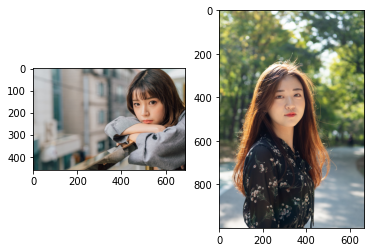

In [7]:
imshow_plot(img_ori)
plt.show()

#### segment

In [8]:
# segment
segvalues = []
output_model = []
for idx in range(len(path_png)):
    val_seg, output = model.segmentAsPascalvoc(path_png[idx])
    segvalues.append(val_seg)
    output_model.append(output)


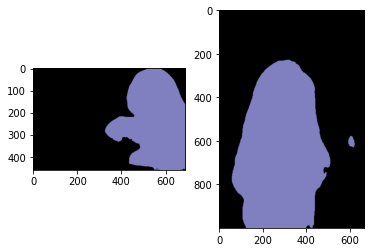

In [9]:
imshow_plot(output_model)
plt.show()

#### 검출 class 확인

In [10]:
# 검출 결과 확인
id_class = []
print(segvalues[0].keys())

for val_seg in segvalues:
    ele_id_class = val_seg['class_ids']
    print(ele_id_class)
    id_class.append(ele_id_class)
    for id_ in ele_id_class:
        print(LABEL_NAME_DEEPLABV3[id_])
    print('\n')



dict_keys(['class_ids', 'masks'])
[ 0 15]
background
person


[ 0 15]
background
person




#### 검출 이미지 확인

(459, 690)
(1000, 667)


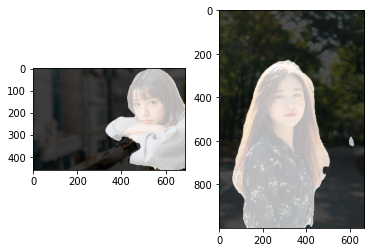

In [11]:
# 검출 이미지 확인
map_seg = []
colormap_class = np.flip(colormap_model[LABEL_NAME_DEEPLABV3.index('person')])
for idx in range(len(output_model)):
    map_ = np.all(output_model[idx] == colormap_class, axis=-1)
    map_seg.append(map_)    
    print(map_.shape)

mask_seg = []
img_overlap = []
for idx in range(len(img_ori)):
    buf_img = img_ori[idx].copy()
    mask_ = map_seg[idx].astype(np.uint8) * 255
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_GRAY2RGB)
    mask_seg.append(mask_)
    buf_img = cv2.addWeighted(buf_img, 0.3, mask_, 0.7, 0.0)
    img_overlap.append(buf_img)

imshow_plot(img_overlap)
plt.show()

#### blu 배경 추출

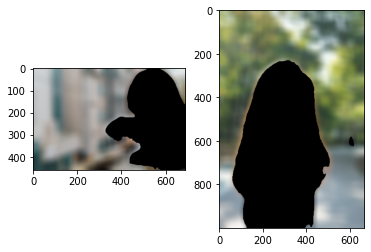

In [12]:
# 배경 blu 처리
img_bg_blur = []
for idx in range(len(img_ori)):
    img_blur = cv2.blur(img_ori[idx], (40, 40))
    img_mask = cv2.bitwise_not(mask_seg[idx])
    buf_bg_blur = cv2.bitwise_and(img_blur, img_mask)
    img_bg_blur.append(buf_bg_blur)
    
imshow_plot(img_bg_blur)
plt.show()

#### 최종 이미지

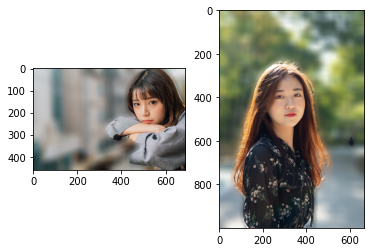

In [13]:
# concat
img_concat = []
for idx in range(len(img_ori)):
    img_concat.append(np.where(mask_seg[idx]==255, img_ori[idx], img_bg_blur[idx]))
imshow_plot(img_concat)
plt.show()

---

### 단체사진

#### 사진 로드

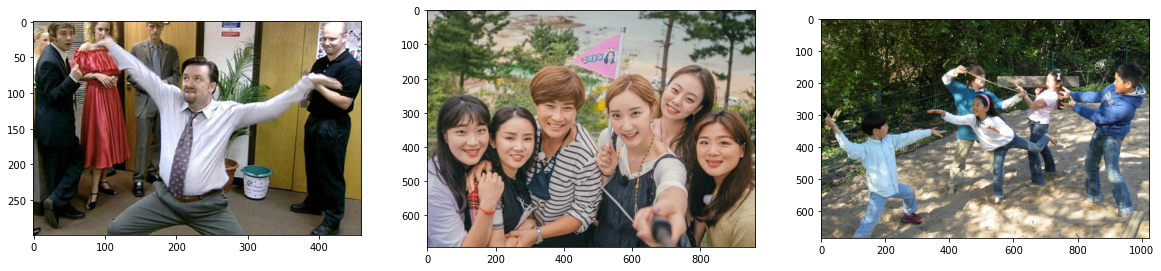

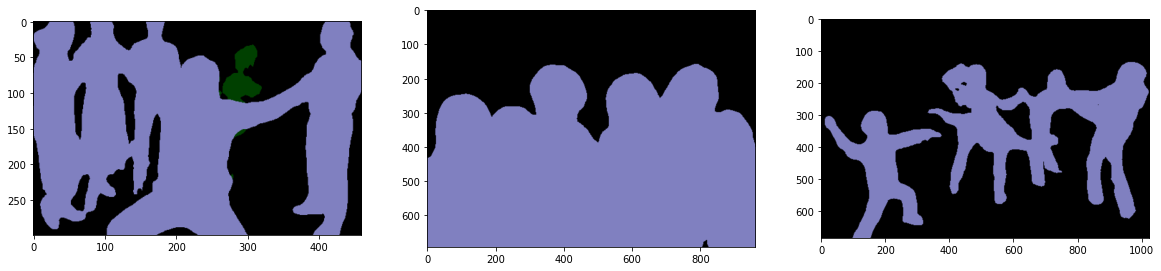

dict_keys(['class_ids', 'masks'])
[ 0 15 16]
background
person
pottedplant


[ 0 15]
background
person


[ 0 15]
background
person


(300, 460)
(693, 961)
(683, 1024)


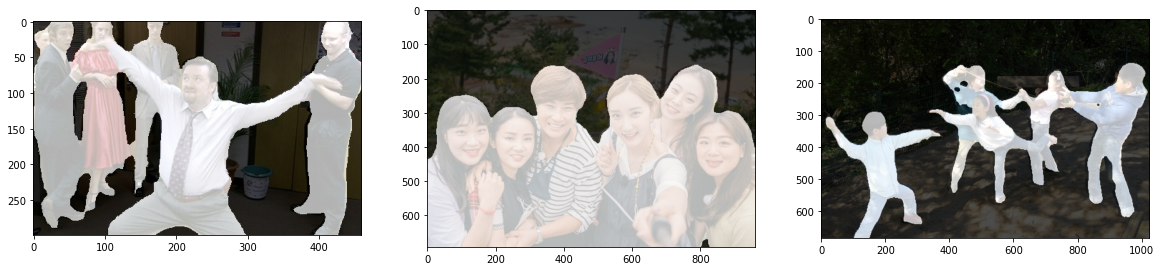

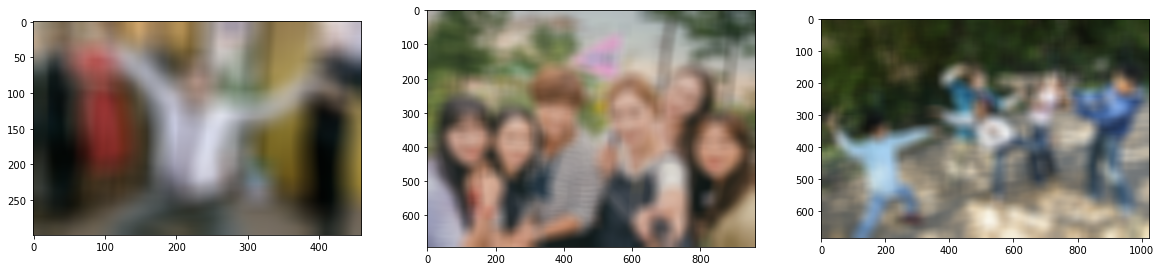

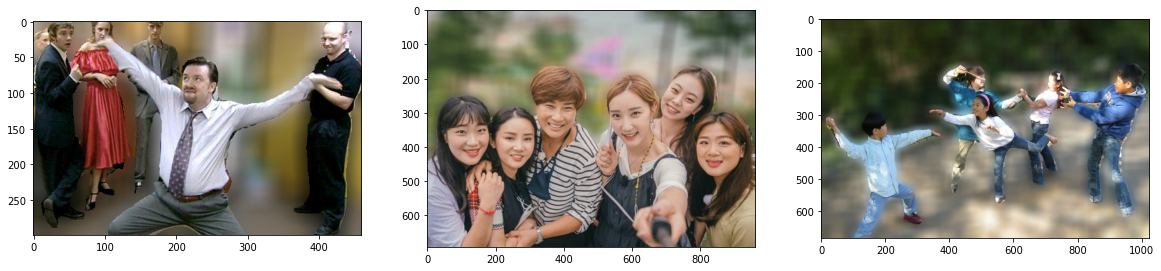

In [33]:
# img load
png_read = read_png_in_dir('./img/group/')
img_ori = png_read[0]
path_png = png_read[1]

concat_img_and_back(img_ori, path_png, colormap_model, 'person', size_blur = (40, 40), size_fig = (20, 20))

## 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진 만들기


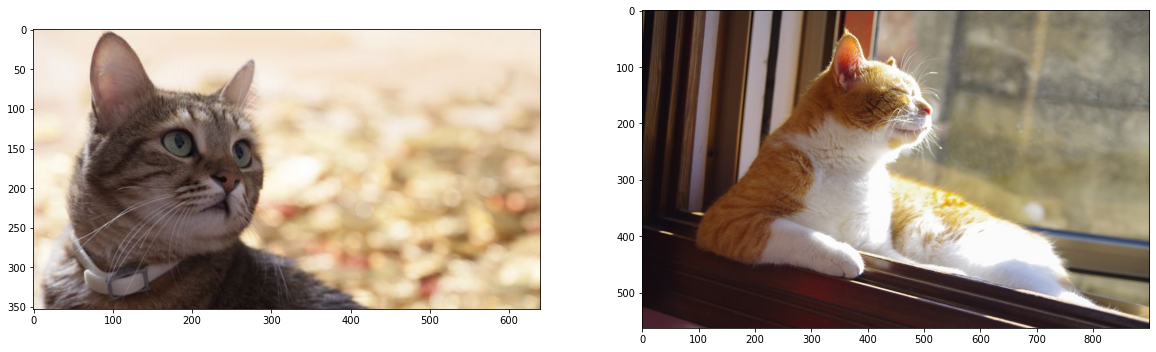

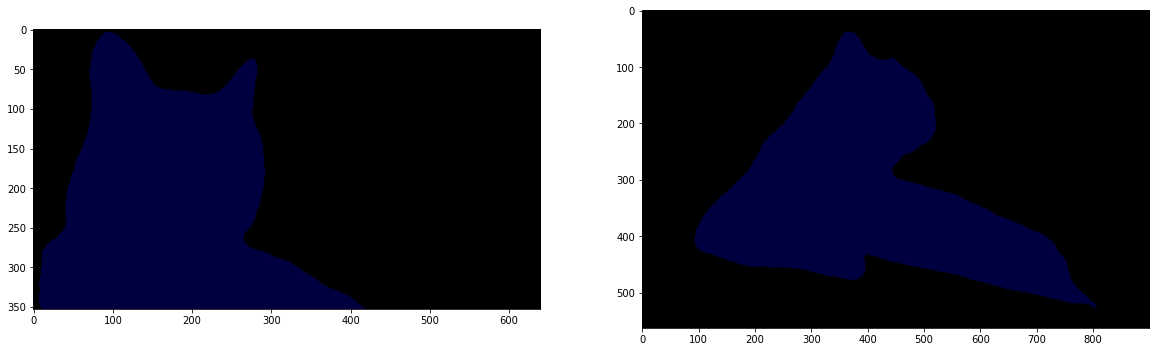

dict_keys(['class_ids', 'masks'])
[0 8]
background
cat


[0 8]
background
cat


(353, 640)
(563, 900)


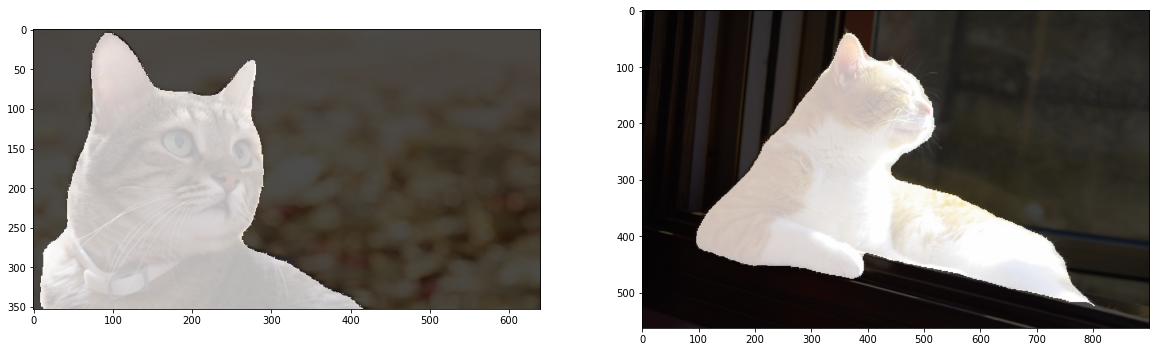

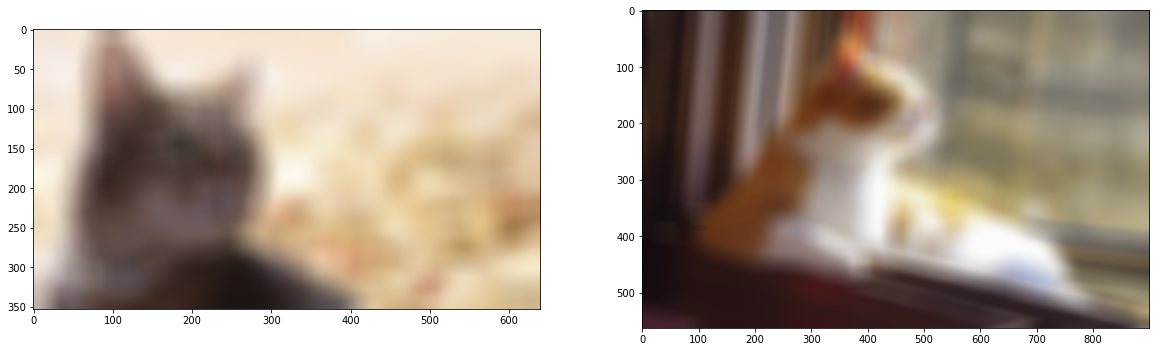

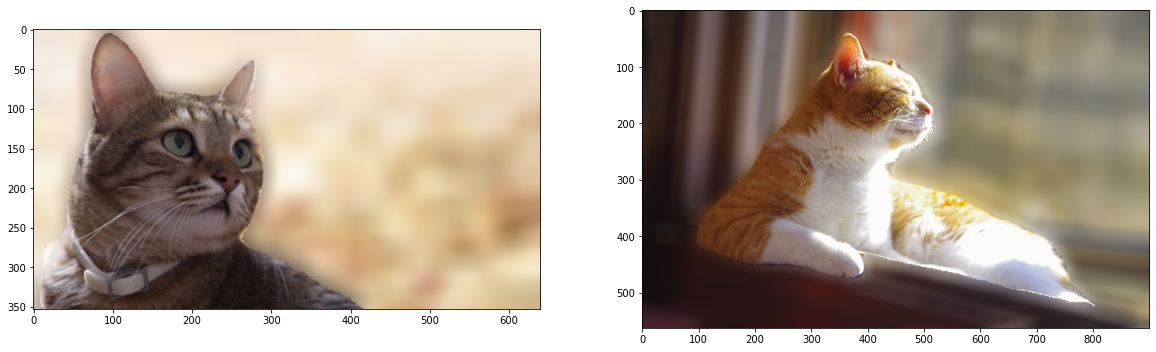

In [34]:
# img load
png_read = read_png_in_dir('./img/cat/')
img_ori = png_read[0]
path_png = png_read[1]

concat_img_and_back(img_ori, path_png, colormap_model, 'cat', size_blur = (40, 40), size_fig = (20, 20))

## 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도


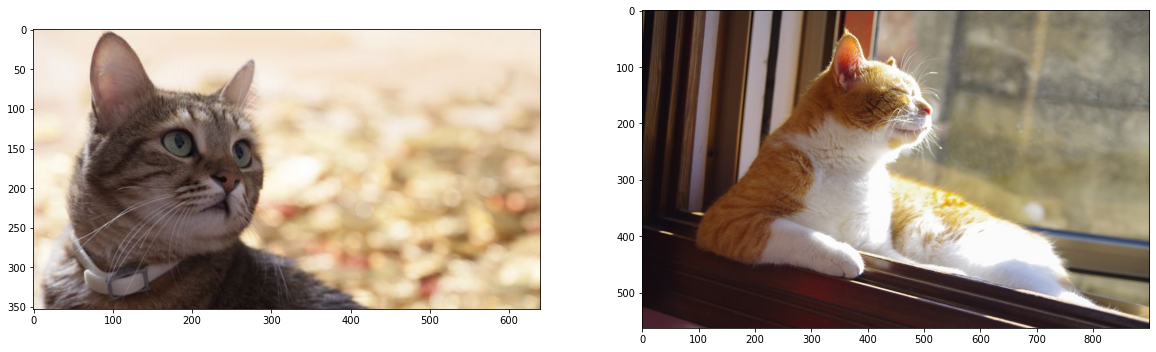

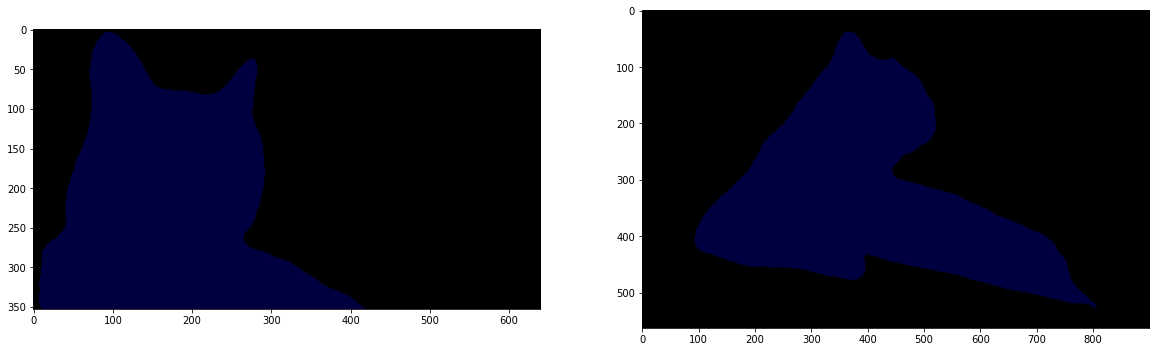

dict_keys(['class_ids', 'masks'])
[0 8]
background
cat


[0 8]
background
cat


(353, 640)
(563, 900)


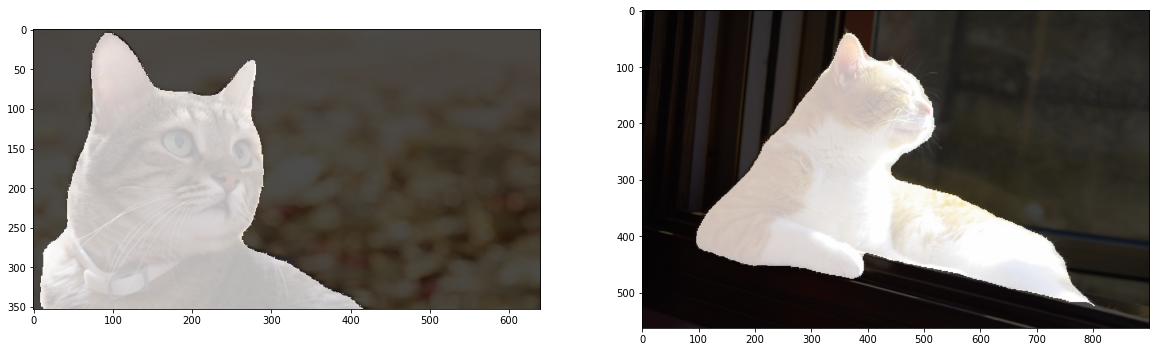

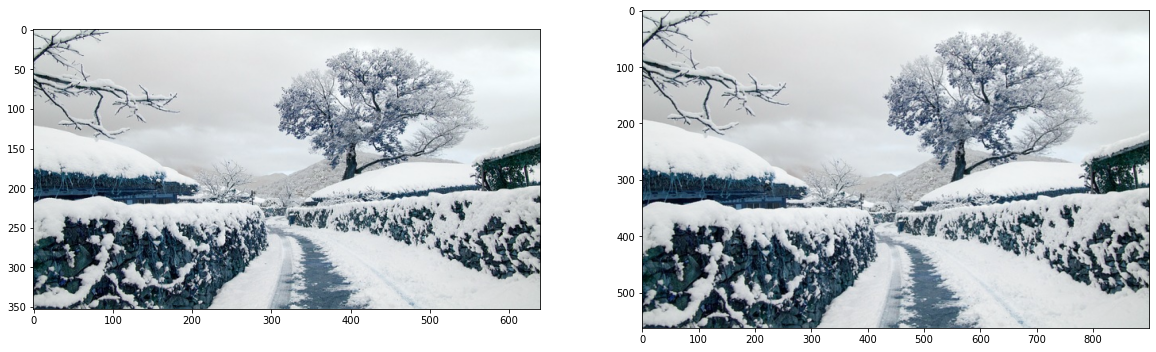

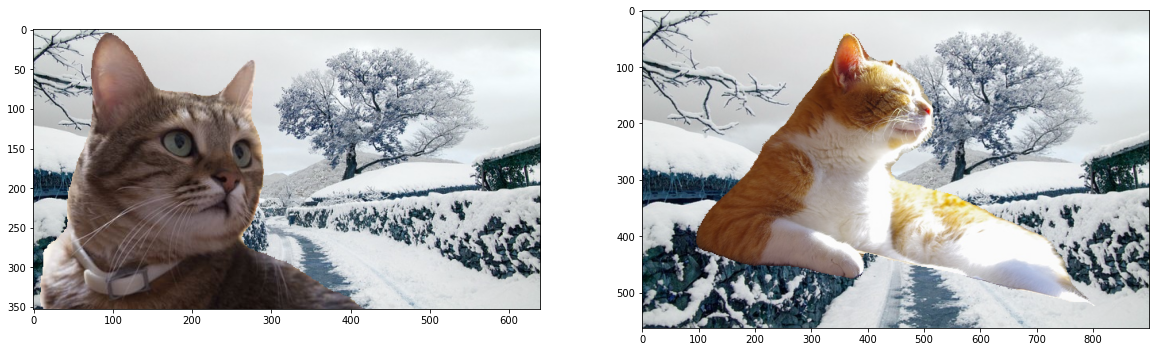

In [41]:
# img load
png_read = read_png_in_dir('./img/cat/')
img_ori = png_read[0]
path_png = png_read[1]

path_back = './img/back/background.png'
img_back_ori = cv2.imread(path_back)
img_back_ori = [img_back_ori for path_ in range(len(img_ori))]

concat_img_and_back(img_ori, path_png, colormap_model, 'cat', img_back = img_back_ori, size_fig = (20, 20))


---

# Step 2. 사진에서 문제점 찾기
- 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 표시. 
- 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

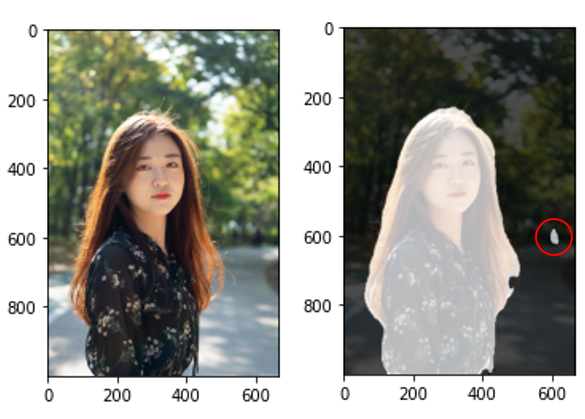


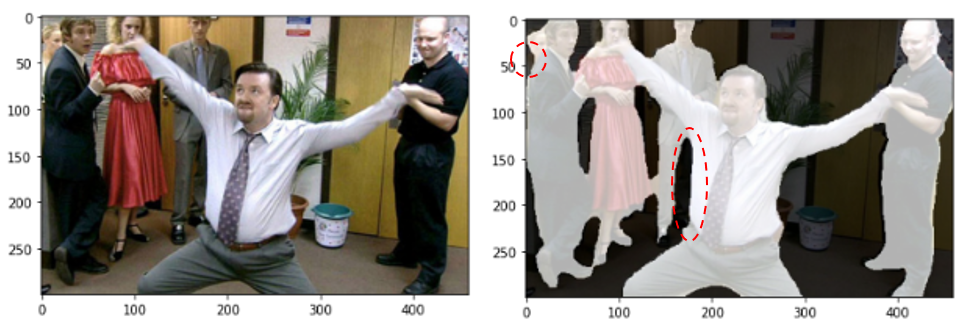

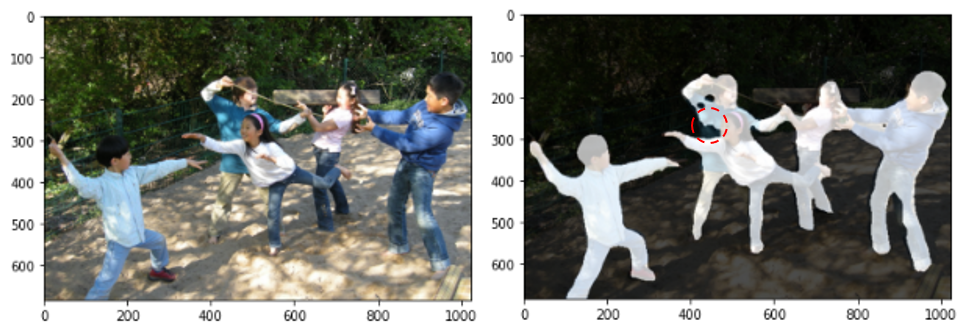

빨간 실선 : 추가 검출 <br>
빨간 점선 : 검출 누락

___

# Step 3. 해결 방법을 제안해 보기
 - 사진의 문제점을 해결할 방안을 정리하여 제안
 - 순서도(Flow Chart) 활용

convolution을 사용하여 물체를 인식하기 때문에 작은 물체들은 무시가 되거나 이상하게 인식 될 수 있고, 큰 물체를 작은 물체로 인식하거나 일정하지 않은 결과가 나올 수 있다. Pooling 을 거치면서 해상도가 줄어든 것을 Upsampling을 통해서 복원하는 방식을 사용해서, 결과가 정확하지 않다는 문제점이 있다.

직접적으로 개체와의 거리(심도)를 측정하여 map을 만들 수 있다면 정확한 결과를 얻을 수 있다.

1. 3D Camera 활용하기
 이미지에서 개체를 구분했지만 3D 이미지 센서를 통해 물체와의 거리를 측정, 개체까지의 거리(심도)를 측정할 수 있다.
 측정된 심도에 따라 Focus point를 정하고 피사계 심도를 정하면 더 정확한 셸로우 포커스 이미지를 얻을 수 있다.
 
1. 소프트웨어 기술 활용
 구글의 struct2Depth에 사용된 방법으로 단안 video의 depth과 ego-motion을 사용한다. 단일 렌즈로 촬영되는 이미지를 사용하여 여러 프레임을 사용하여 심도를 측정, 여러 보완 기술을 사용하여 깊이 지도와 시차지도 생성하여 3D 장면과 개별 개체 움직임을 모델링 한다. 이를 통해 단일 렌즈로 개선된 Depth를 구할 수 있다.
 
